<a href="https://colab.research.google.com/github/Repocr/Code-Decode-tool/blob/master/Copy_of_ProyectoRobotTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Robot Trading

##Declación de variables e importar bibliotecas

In [ ]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.1.4
------
Name: numpy
Version: 1.26.4
        Name: lapack-lite
        Name: tempita
        Name: dragon4
        Name: libdivide
        Name: Meson
        Name: spin
        Name: OpenBLAS
        Name: LAPACK
        Name: GCC runtime library
        Version 3.1, 31 March 2009
                               Version 3, 29 June 2007
          5. Conveying Modified Source Versions.
          14. Revised Versions of this License.
        Name: libquadmath
------
Name: matplotlib
Version: 3.7.1


##Obteniendo los datos historicos

Se crea la función importar_base_bitcoin


* Se declaran nuevamente las variables gobales
* Con la biblioteca datatime calculo la fecha de inicio y fin con los formatos %Y-%m-%d
* Con la biblioteca yfinance se obtienen los datos de BTC-USD con la función download definiendo la fecha de inicio, de fin y el intervalo de tiempo.
* Se crea un dataframe en pandas con la información



In [ ]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  import yfinance as yf #biblioteca para obtener el precio del bitcoin
  from datetime import datetime, timedelta #bibliotecas para el calculo de dias

  fecha_fin = datetime.today().strftime('%Y-%m-%d')
  fecha_inicio = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')
  df_bitcoin =  pd.DataFrame(yf.download('BTC-USD', start=fecha_inicio,end= fecha_fin, interval='5m')) # se guarda el historico creando un dataframe


In [ ]:
importar_base_bitcoin()

[*********************100%***********************]  1 of 1 completed


##Obteniendo las tendencias y el precio actual

Se crea la función extraer_tendencias
* Se declara de nuevo las variables globales.
* Con WebScraping accedo a los datos de 'https://coinmarketcap.com/'
* Busco el valor del precio actual del Bitcoin en Dolares y lo almaceno en precio_actual previamente tratandolo para que sea un float
* Busco la variación y defino si la tendencia es 'baja' o 'alta',

El valor de variación solo es positivo a pesar de que sea baja.
Algo particular esque en esta etiqueta div, hay una etiqueta div que contiene información sobre la fecha anterior de la variación.
En caso de que sea positiva muestra 'icon-Caret-up' y en el caso de que sea negativa 'icon-Caret-down'. Esto define si nuestra tendencia es alta o baja.

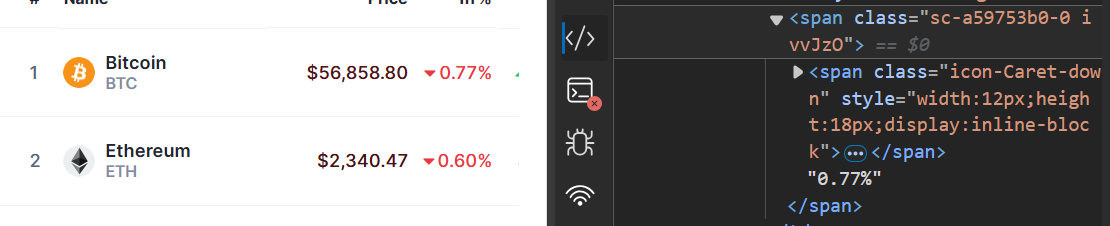

In [ ]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  from urllib.request import urlopen
  from bs4 import BeautifulSoup

  url = 'https://coinmarketcap.com/'
  response = urlopen(url)
  html = response.read()
  soup = BeautifulSoup(html,'html.parser')
  precio_actual = float(soup.find('div',class_ = 'sc-b3fc6b7-0 dzgUIj').get_text().replace('$','').replace(',',''))
  tendencia = 'baja' if 'down' in soup.find('span',class_ = 'sc-a59753b0-0 ivvJzO').find('span')['class'][0] else 'alta'


## Obteniendo la media y limpieza de datos del DF

Se crea la función limpieza_datos.
* Declado de nuavo las variables goblales.
* Creo una copia del df para el tramiendo de datos.
* Elimino las columnas que tengan el Volumen en 0
* Calculo los cuartiles q1 y q3
* Filtro la base para obtener los datos entre los cuartiles 1 y 3
* Hago el calculo del promedio y lo almaceno en media_bitcoin

No se detectaron valores nulos en el dt.

No se detectaron valores duplicados en el indice.

In [ ]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2015 entries, 2024-09-03 00:00:00+00:00 to 2024-09-09 23:55:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2015 non-null   float64
 1   High       2015 non-null   float64
 2   Low        2015 non-null   float64
 3   Close      2015 non-null   float64
 4   Adj Close  2015 non-null   float64
 5   Volume     2015 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.2 KB


In [ ]:
df_bitcoin.isnull().sum() #Validación de valores nulos. No hay valores nulos.

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df_bitcoin.index.duplicated(keep=False).sum() #Validación de duplicidad en el index. No hay duplicidad.

0

In [ ]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin_limpio = df_bitcoin
  df_bitcoin_limpio.drop(index=df_bitcoin_limpio.query('Volume==0').index, axis = 0 , inplace=True) #Se elimmina filas con volumen 0
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  filtro = (df_bitcoin_limpio['Close']>= Q1) & (df_bitcoin_limpio['Close']<= Q3) #filtro los cuartiles 1 y 3 para eliminar los outliers
  media_bitcoin = df_bitcoin_limpio[filtro]['Close'].mean() #obtener el promedio aplicando el filtro




##Algoritmo de decisión.

Se crea la función tomar_decisiones.
* Se declaran las variables goblales.
* Defino mi mi vairbales algoritmo_decisión.


Si el precio_actual es mayor o igual a la media_bitcoin y además la tendencia es baja se debe guardar 'Vender'
Si el precio_actual es menor a la media media_bitcoin y además la tendencia es alta se debe guardar 'Comprar'
Caso contrario se debe guardar 'Esperar'

In [ ]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  algoritmo_decision = 'Vender'if (precio_actual >= media_bitcoin) & (tendencia == 'baja') \
  else 'Comprar' if (precio_actual < media_bitcoin) & (tendencia == 'alta') \
  else 'Esperar'

##Creando la visualización

Se crea la función visualización:
* Se crea la columna Promedio con el valor de la media_bitcoin.
* Con Mathplotlib defino el tamaño del grafico y el titulo
* Creo la linea de Close
* Creo la linea de promedio
* Creo la anotación de la Acción Sugerida
* Muestro el grafico

In [ ]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin['Promedio']= media_bitcoin
  plt.figure(figsize=(16,5))
  plt.title("Robot Trading")
  df_bitcoin['Close'].plot()
  df_bitcoin['Promedio'].plot()
  plt.annotate(f'Accion: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]))
  plt.show()

##Automatización

Para crear la automatización es necesario importar las bibliotecas
* time, para retrasar el tiempo de ejecución o para defenir con que periodo se debe ejecutar.
* clear_output de IPython.display para limpiar la pantalla y mostrar el nuevo gráfico de análisis.

Luego se crea un bucle infinito donde se ejecutan las funciones que creamos anteriormente, en cada repetición se limpia la pantalla, se ejecutan las funciones y se espera 5 minutos antes de ejecutarse de nuevo.


[*********************100%***********************]  1 of 1 completed


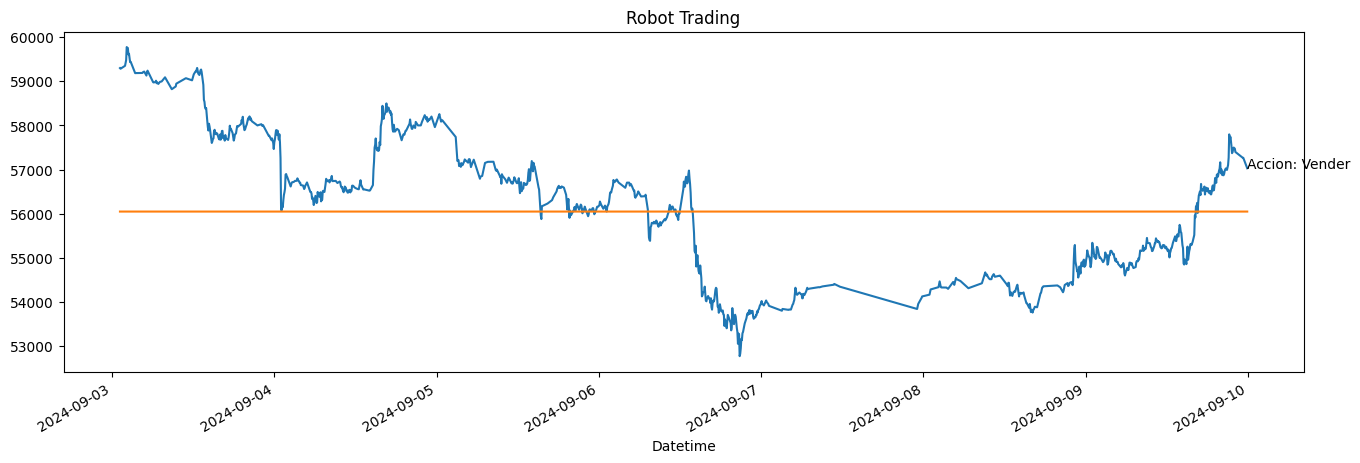

KeyboardInterrupt: 

In [ ]:
from IPython.display import clear_output
import time
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)